In [422]:
# Importing Libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import svd
from scipy.linalg import sqrtm
from scipy.sparse import csr_matrix
import itertools

# Reading Data

In [432]:
## Reading Data
ratings = pd.read_csv('data/u.data', sep = '\t', header = None, names = ['user_id', 'movie_id', 'rating', 'timestamp'], encoding = 'utf-8')
user = pd.read_csv('data/u.user', sep = '|', header = None, names = ['user_id', 'age', 'gender', 'occupation', 'zip_code'], encoding = 'utf-8')
movie = pd.read_csv('data/u.item', sep = '|', encoding="iso-8859-1", header = None, names = ["movie_id", "movie_title", "release_date", "video_releasedate", "IMDbURL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])

In [433]:
# Removing extra columns
ratings = ratings.drop(columns = ['timestamp'])
print(ratings.shape)
ratings.head(2)

(100000, 3)


,user_id,movie_id,rating
0,196,242,3
1,186,302,3


In [434]:
movie = movie.drop(columns = ["release_date", "video_releasedate", "IMDbURL"])
print(movie.shape)
movie.head(2)

(1682, 21)


,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [435]:
## Compressing the genres into a single columns as an array  
def compress_columns(row, li): 
    l = []
    for i in li:
        if row[i] == 1 :
            l.append(str(i))
    return l    

li_genres = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

movie['genres'] = movie.apply(compress_columns, li = li_genres, axis = 1)

In [436]:
movie['genres']

0       [Animation, Children's, Comedy]
1         [Action, Adventure, Thriller]
2                            [Thriller]
3               [Action, Comedy, Drama]
4              [Crime, Drama, Thriller]
                     ...               
1677                            [Drama]
1678                [Romance, Thriller]
1679                   [Drama, Romance]
1680                           [Comedy]
1681                            [Drama]
Name: genres, Length: 1682, dtype: object

In [437]:
## Combining Movie and rating table

df = pd.merge(ratings,movie,on='movie_id')
df = df[['user_id', 'movie_id', 'rating', 'movie_title','genres']]
print(df.shape)
df.tail(10)

(100000, 5)


,user_id,movie_id,rating,movie_title,genres
99990,416,1594,5,Everest (1998),[Documentary]
99991,648,1626,1,Nobody Loves Me (Keiner liebt mich) (1994),"[Comedy, Drama]"
99992,655,1645,4,"Butcher Boy, The (1998)",[Drama]
99993,747,1659,1,Getting Away With Murder (1996),[Comedy]
99994,916,1682,3,Scream of Stone (Schrei aus Stein) (1991),[Drama]
99995,840,1674,4,Mamma Roma (1962),[Drama]
99996,655,1640,3,"Eighth Day, The (1996)",[Drama]
99997,655,1637,3,Girls Town (1996),[Drama]
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1...",[Drama]
99999,655,1641,3,Dadetown (1995),[Documentary]


# Exploring Data

In [438]:
print('Total Ratings:  ' + str(df.user_id.count()))
print('unique users:  ' + str(df.user_id.nunique()))
print('unique movies:  ' + str(df.movie_id.nunique()))

Total Ratings:  100000
unique users:  943
unique movies:  1682


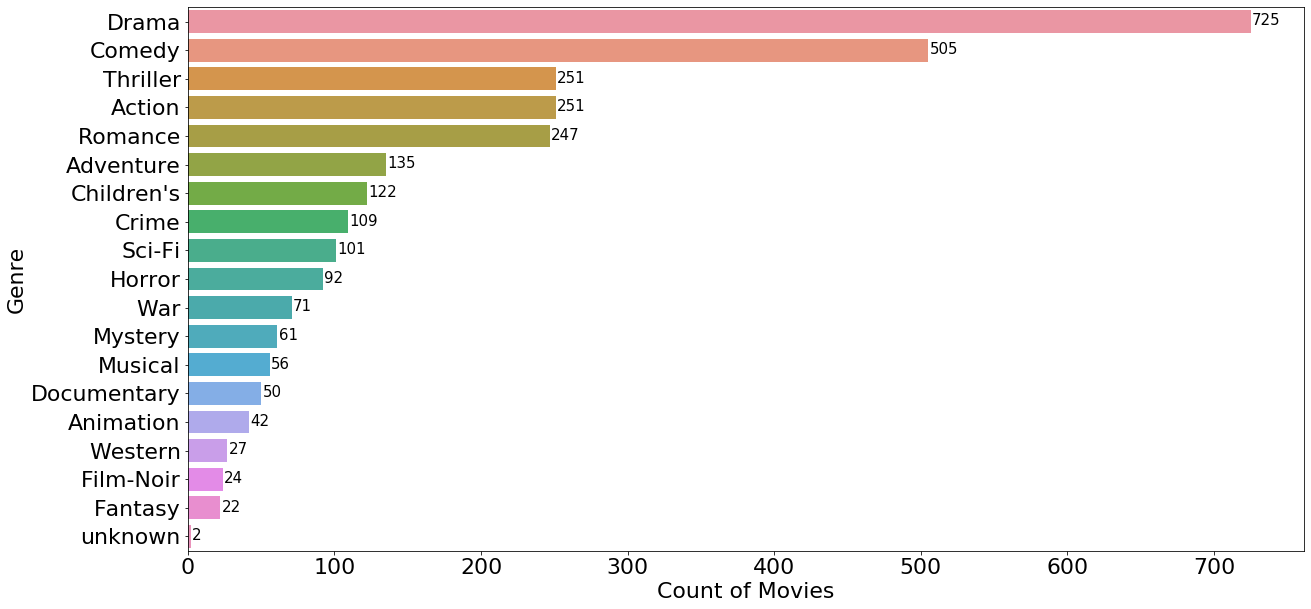

In [442]:
# Lets split the genres of each movie into a list

def number_of_genres(x):
    return len(x['genres'])

movie['genres_count'] = movie.apply(number_of_genres,axis = 1)

# a = [ i for x in movies['genres_list'] for i in x]
l = pd.Series(np.concatenate(movie['genres']))

# Value_count of genres
x = pd.Series(l.value_counts())

### Plotting Count for each genre
plt.figure(figsize=(20,10))
ax = sns.barplot(x,x.index)
for p in ax.patches:
        count = '{:.0f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.9
        y = p.get_y() + p.get_height()/1.5
        ax.annotate(count, (x, y), fontsize = 15)
plt.xticks(fontsize = 22)
plt.xlabel('Count of Movies',fontsize=22)
plt.ylabel('Genre', fontsize=22)
plt.yticks(fontsize = 22)
plt.show()

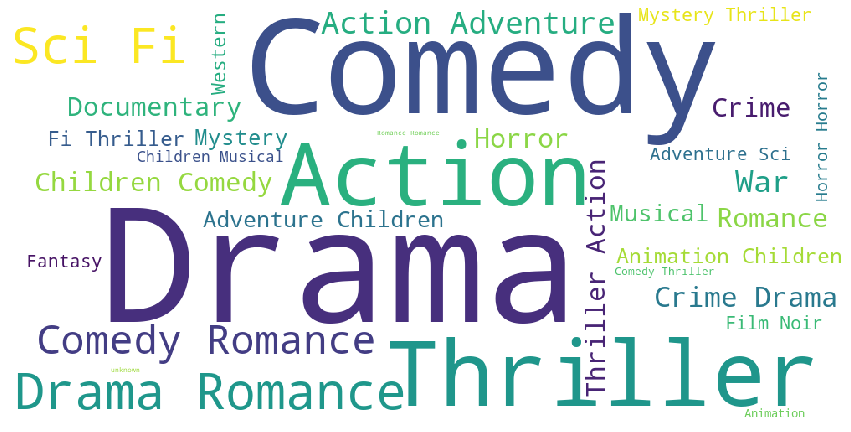

In [153]:
# Also plotting word cloud for above
#convert list to string and generate
from wordcloud import WordCloud, STOPWORDS
unique_string=(" ").join(l)
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

###### Word cloud of movie titles

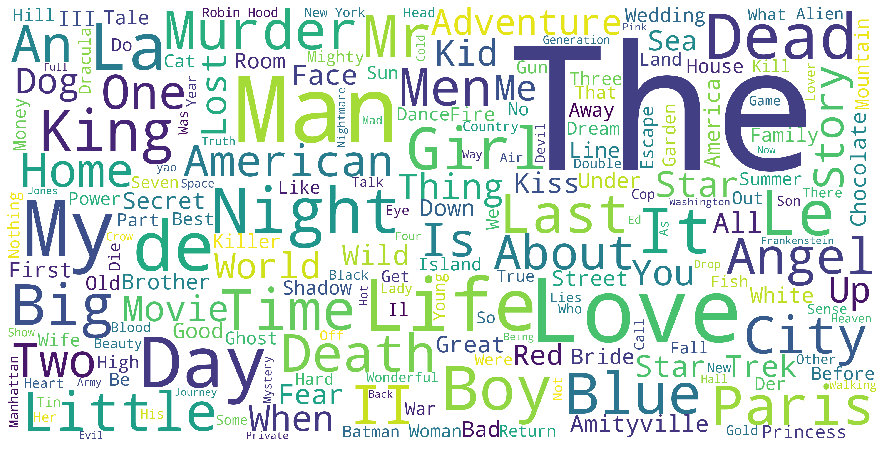

In [155]:
## Word Cloud for Movie Titles
# Import new libraries
%matplotlib inline
import wordcloud


# Word cloud of movie titles
title_corpus = ' '.join(movie['movie_title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

###### Count of genres per movie

,genres_count
1,49.5
2,33.8
3,12.8
4,3.0
5,0.7
6,0.2


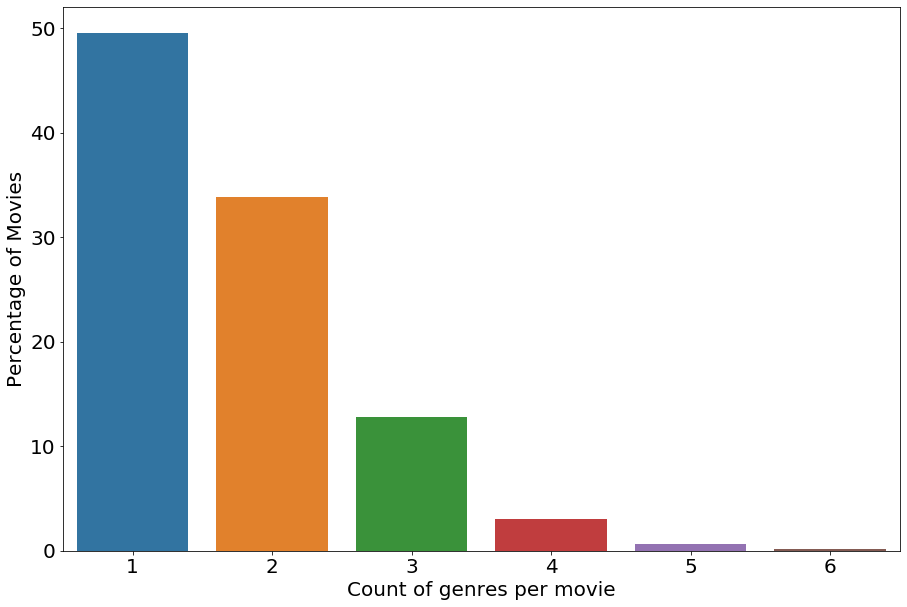

In [169]:
def number_of_genres(x):
    return len(x['genres'])

movie['genres_count'] = movie.apply(number_of_genres,axis = 1)

x = pd.Series(movie['genres_count'].value_counts(normalize=True).mul(100))


plt.figure(figsize=(15,10))
ax = sns.barplot(x.index,x)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Count of genres per movie', fontsize = 20)
plt.ylabel('Percentage of Movies', fontsize = 20)

pd.DataFrame(x.sort_values(ascending = False).round(1))

## Ratings

4    34.174
3    27.145
5    21.201
2    11.370
1     6.110
Name: rating, dtype: float64


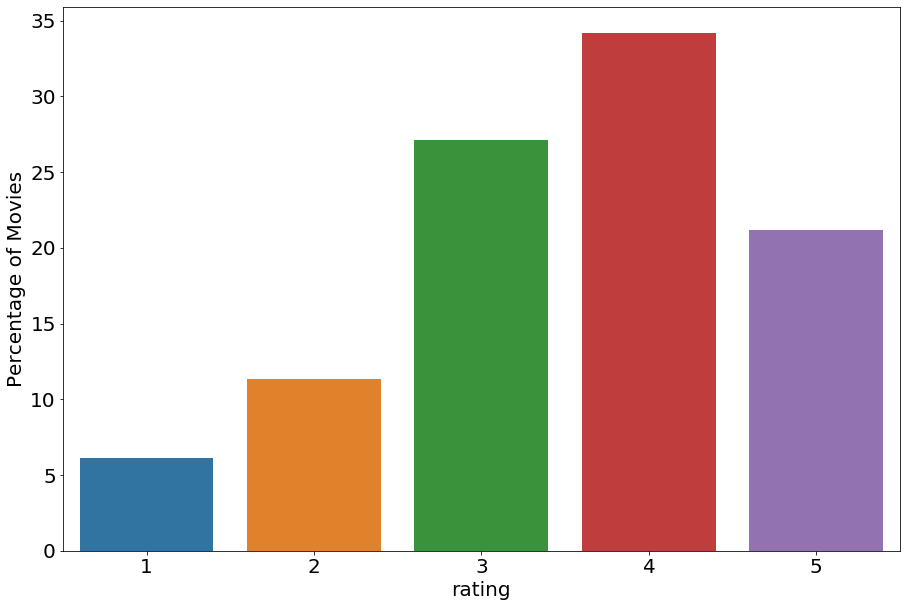

In [170]:
x = pd.Series(df['rating'].value_counts(normalize=True).mul(100))

### Plotting rating counts
plt.figure(figsize=(15,10))
ax = sns.barplot(x.index,x)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('rating', fontsize = 20)
plt.ylabel('Percentage of Movies', fontsize = 20)

print(x.sort_values(ascending = False))

More than half of the movies are rated >=4

In [443]:
df.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

# Recommendation System

## Content Based Filtering

We will use genre of the movie to calculate similarity of content. 

In [302]:
movie_genre = movie.drop(columns = ['movie_title', 'genre_combined', 'genres','genres_count']).set_index('movie_id')
movie_genre.head(2)

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [304]:
from sklearn.metrics.pairwise import pairwise_distances
content_similarity = 1 - pairwise_distances(movie_genre.values, metric='cosine')

Recommending tip n movies based on similarity of genres, given a movie title

In [314]:
movie = movie.set_index('movie_id')
movie.head(2)

,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre_combined,genres,genres_count
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]","[Animation, Children's, Comedy]",3
2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,"[Action, Adventure, Thriller]","[Action, Adventure, Thriller]",3


In [397]:
def content_rec(title, n):
    
    # Getting movie_id from the title
    idx = movie[movie['movie_title'] == title].index.values
    
    # Ranking most similar movies  
    sorted_movie_index = (-content_similarity[idx[0]-1,:].flatten()).argsort()[:n+1]
    
    # removing the given movie from sorte list
    final_index = sorted_movie_index[sorted_movie_index != idx[0]-1]
    
    # Removing the given title from this list
    
    return movie.iloc[final_index,:].movie_title

Finding top 5 movies which are similar in content to GoldenEye (1995)

In [408]:
content_rec('GoldenEye (1995)', 5)

movie_id
1314    Surviving the Game (1994)
1016               Con Air (1997)
827               Daylight (1996)
117              Rock, The (1996)
118                Twister (1996)
Name: movie_title, dtype: object

## Collaborative Filtering

In [174]:
# Train Test Split
# Taking 20% as the test data
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2)
print(train_data.shape)
print(test_data.shape)


(80000, 6)
(20000, 6)


In [185]:
#User (rows) and movie (columns) matrix, with values as ratings
#Train Data
train_pivot = train_data.pivot(index = 'user_id', columns = 'movie_id', values = 'rating')
train_matrix = train_pivot.values
#Test data
test_pivot = test_data.pivot(index = 'user_id', columns = 'movie_id', values = 'rating')
test_matrix = test_pivot.values

In [184]:
print(type(train_matrix))
train_matrix

<class 'pandas.core.frame.DataFrame'>


movie_id,1,2,3,4,5,6,7,8,9,10,...,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,NaN,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Its a sparse matrix, with majority ratings missing. 

In [257]:
## Percentage of Non Null Values in the matrix
np.count_nonzero(train_matrix)/(train_matrix.shape[0]*train_matrix.shape[1])*100

# 1 - np.isnan(train_matrix).sum() / train_matrix.size   # When Null not susbstituted with 0

5.157181213678133

In [192]:
train_matrix.shape

(943, 1645)

These metrices are sparse matrix!

In [318]:
a = 5

###### Calculating cosine similarity from the training data

In [199]:
## Replacing NaN rating with zero
train_matrix = np.nan_to_num(train_matrix, nan = 0)
test_matrix = np.nan_to_num(test_matrix, nan = 0)

In [200]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
item_similarity = 1 - pairwise_distances(train_matrix.T, metric='cosine')


print(user_similarity.shape)
print(item_similarity.shape)

(943, 943)
(1645, 1645)


Predicting user rating

In [201]:
def predict(rating_matrix, similarity, type='user'):
    if type == 'user':
        mean_user_rating = rating_matrix.mean(axis=1) ## Mean rating 
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (rating_matrix - mean_user_rating[:, np.newaxis])
        # Using similarity as weights
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = rating_matrix.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [202]:
item_prediction = predict(train_matrix, item_similarity, type='item')
user_prediction = predict(train_matrix, user_similarity, type='user')

In [203]:
print(item_similarity.shape)
print(user_similarity.shape)
print(train_matrix.shape)
print(train_matrix.dot(item_similarity).shape)
print(train_matrix.dot(item_similarity).shape)

(1645, 1645)
(943, 1645)
(943, 1645)


Evaluating Predictions

In [204]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    ## We will predict values only where we have the test ratings, thus nonzero
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [205]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_matrix)))

User-based CF RMSE: 3.246578644539899
Item-based CF RMSE: 3.349806698117398


Recommending Movies based on predicted Ratings

In [280]:
# Predict top n unwatched movies by a given user

def predict(user_id, n_movies, rating_matrix, similarity, type='user'):
    if type == 'user':
        mean_user_rating = rating_matrix.mean(axis=1) ## Mean rating 
        #Creating np.newaxis to rescale rating to the orgional format
        ratings_diff = (rating_matrix - mean_user_rating[:, np.newaxis])
        # Using similarity as weights
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T        
    elif type == 'item':
        pred = rating_matrix.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    
    ### Filtering unwatched movies by the user
    movie_index = pred[user_id-1,:].nonzero()
    predicted_ratings = pred[user_id-1, movie_index] # 1 X no. of unwatched movies dimensional array
    
    ## Movie index post sorting the predicted ratings
    idx = (-predicted_ratings.flatten()).argsort()[:n_movies]
    
    return movie.iloc[idx].movie_title


Top 5 movie recommendation for userd_id = 7, based on **user based collaborative filtering**

In [282]:
predict(7, 5, train_matrix, user_similarity, type='user') # user_id = 7 , n_movies = 5

49                     Star Wars (1977)
99                         Fargo (1996)
173      Raiders of the Lost Ark (1981)
180           Return of the Jedi (1983)
97     Silence of the Lambs, The (1991)
Name: movie_title, dtype: object

Top 5 movie recommendation for userd_id = 7, based on **item based collaborative filtering**

In [283]:
predict(7, 5, train_matrix, item_similarity, type='item') # user_id = 7 , n_movies = 5

598    Police Story 4: Project S (Chao ji ji hua) (1993)
599                Daniel Defoe's Robinson Crusoe (1996)
642                                  The Innocent (1994)
620      Davy Crockett, King of the Wild Frontier (1955)
597                              Big Squeeze, The (1996)
Name: movie_title, dtype: object

## Matrix Factorization (SVD)

In [449]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix.
# K corresponds to number of singular values to be computed
u, s, vt = svds(train_matrix, k = 10)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_matrix)))

User-based CF MSE: 3.2800094835623863


Here K acts as a hyper paramter which can be tuned for a better accuracy

In [450]:
def predict_svd(user_id, n_movies): 
    pred = np.dot(np.dot(u, s_diag_matrix), vt)
    ### Filtering unwatched movies by the user
    movie_index = pred[user_id-1,:].nonzero()
    predicted_ratings = pred[user_id-1, movie_index] # 1 X no. of unwatched movies dimensional array
    
    ## Movie index post sorting the predicted ratings
    idx = (-predicted_ratings.flatten()).argsort()[:n_movies]
    
    return movie.iloc[idx].movie_title

In [451]:
predict_svd(7, 5)

184                       Psycho (1960)
233                         Jaws (1975)
97     Silence of the Lambs, The (1991)
442                   Birds, The (1963)
182                        Alien (1979)
Name: movie_title, dtype: object

**Thank You**